#  IV-curve modeling

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook introduces some tools to estimate the IV-curve at the array level to get the maximum power point.

It is broken down into two parts:

1. **IV curve modeling**: Estimates IV-curve at the module level and, then at the array level
2. **DC power estimation**: DC power estimation with IV curves and comparison to real values.

Some extra commands are introduced in the introduction of this notebook.

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

To generate an IV curve, the following parameters are needed for the DeSoto 1-diode 5-parameter model:

- Photocurrent ($I_L$): The current generated by the PV module due to light exposure, which is typically proportional to the solar irradiance.

- Saturation Current ($I_0$): The dark saturation current of the diode, which represents the recombination losses in the PV cell.

- Series Resistance ($R_s$): The resistance in series, representing the internal resistance of the PV cell and the connections.

- Shunt Resistance ($R_{sh}$): The resistance in parallel, which accounts for leakage currents in the PV cell.

- The modified Diode Ideality Factor ($a$): product of the diode ideality factor, number of cells and cell thermal voltage.

The Single Diode model Equation:

 $$I = I_L - I_0 \cdot (exp(\frac{V + I \cdot R_s}{a}) - 1) - \frac{V+ I \cdot  R_s}{R_{sh}} $$

Reference: W. De Soto, S.A. Klein, W.A. Beckman, Improvement and validation of a model for photovoltaic array performance, Solar Energy, Volume 80, Issue 1, 2006

# 0. Extra commands

This section introduces few commands useful for the notebook.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate V from a list of current I with the deSoto model
from pvlib.pvsystem import v_from_i
from tqdm import tqdm
from scipy.optimize import curve_fit # to perform regression

# Some warnings appear when calculating the IV-curve because of wrong inputs within a logarithm
# Those two lines, avoid to print the warnings
import warnings
warnings.filterwarnings("ignore")

#### Create and manipulate List / np.array

In [ ]:
# Create a list of values starting from -5 to 20 with a step 2
v_index= np.arange(-5, 20, 2)
print(v_index)

i_index = 10 - v_index
print(i_index)

[-5 -3 -1  1  3  5  7  9 11 13 15 17 19]


In [ ]:
# To create a loop over 5 iterations:
for i in range(5):
    print(i)

0
1
2
3
4


In [ ]:
# Tqdm enable to see the progress when doing loops, you might need to indicate the total number of elements to go through with the argument "total"
for i in tqdm(range(10000000), total=len(range(10000000))):
    _

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000000/10000000 [00:02<00:00, 4781449.78it/s]


#### Plots commands

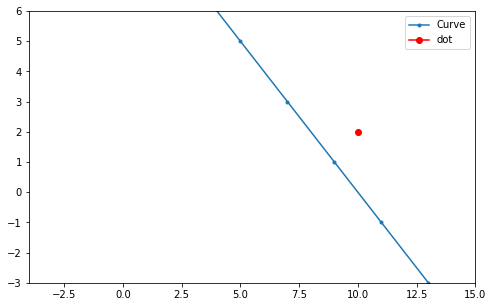

In [ ]:
# Store values with a DataFrame
iv_df = pd.DataFrame()
iv_df["i"] = i_index
iv_df["v"] = v_index

# Create a new figure with plt.subplots
fig, ax = plt.subplots(1,1, figsize=(8,5))

plt.plot(iv_df["v"], iv_df["i"], marker=".", label="Curve")
plt.plot(10, 2, color="red", marker="o", label="dot") # Plot one dot in red

plt.ylim([-3, 6]) # Scale Y axis between -3 and 6
plt.xlim([-4, 15]) # Scale X axis between -4 and 15

plt.legend() # Show the labels

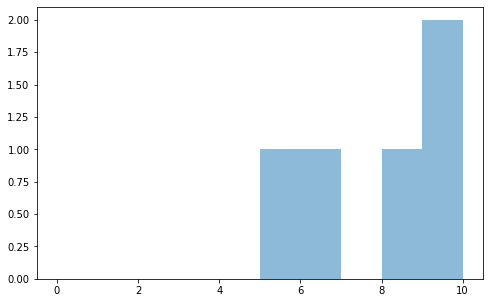

In [ ]:
# plot an histogram, ie how many values there are per bins
dummy_list = [10,5,6,10,8]

fig, ax = plt.subplots(1,1, figsize=(8,5))

# Alpha is the "transparency" of the bars
# bins define the limits of the bins in which the number of values are counted up
_ = plt.hist(dummy_list, alpha=0.5, bins=np.arange(0,11,1))

#### Get maximums in a DataFrame

In [ ]:
print(iv_df["v"].max())
print(iv_df["v"].idxmax())

print("\n DataFrame") # ''\n': enables to return to the line
print(iv_df)

print("\n Row")
idx = iv_df["v"].idxmax()
print(iv_df.loc[idx])

19
12

 DataFrame
     i   v
0   15  -5
1   13  -3
2   11  -1
3    9   1
4    7   3
5    5   5
6    3   7
7    1   9
8   -1  11
9   -3  13
10  -5  15
11  -7  17
12  -9  19

 Row
i    -9
v    19
Name: 12, dtype: int32


# I. IV curve modeling

IV curves are estimated at the array level in this section.

The cell below provides the STC characteristics of the studied module.

In [ ]:
k =  8.617333262e-05 # Boltzmann constant [eV]

# STC 5-parameters
I_L_ref= 6.041432734377855 # A
I_o_ref=  7.978171413949759e-13 # A
R_s= 0.8019879393203573 # Ohm
R_sh_ref= 422.9947763950826 # Ohm
a_ref= 2.3491351509996625 # V

# Thermal coefficient: short-circuit current
alpha_sc= 0.00332 # A / °C

### Exercice: Five parameters / Single Diode model

Calculates the five parameters for the single diode model for:
- 800 W
- 40 °C

In [ ]:
# Develop your code here !

### Exercice: IV-curve at the module level

Estimate the IV-curve for the following conditions:
- 800 W
- 40 °C


**Follow the steps:**

1. Create a list of current ranging from -1A to 10A with a step of 0.0001 according to the function from numpy "range".

2. Calculate the current according to the function from "v_from_i".

3. Store the values in a DataFrame with two columns ["v","i"] for voltage and current respectively.

*Hints:*

The function "v_from_i" from pvlib come in handy. It enables to calculate the voltage values from the current. Check it out!  https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.v_from_i.html#pvlib.pvsystem.v_from_i.

Notice that "v_from_i" can directly take a list as input for the "current" argument.



**Be careful: the DeSoto model does not estimate correctly the negative-voltage quadrant**

In [ ]:
# Develop your code here !

### Exercice: IV-curve utils functions

- Create a function to extract the maximum power from an IV-curve.

- Plot the current I as function of the voltage V and show the maximum point point on the curve (only on the positive quadrant !).

- Plot the power P as function of the voltage V and show the maximum point point on the curve (only on the positive quadrant !).

In [ ]:
# Develop your code here !

### Exercice: Diode Bypass effect

Add the effect of three (ideal) bypass diodes with a breakdown voltage equal to 0.5 V on the IV dataframe

*Hints:* Change the voltage values straight to -1.5 V for all the rows with voltage under -1.5V,. The "clip()" method can be used.

In [ ]:
# Develop your code here !

### Exercice: IV-curve at the array level

Combine the IV curves of 12 modules connected in series. The Voltages should be summed up.

Plot the IV curve at the array level.

*Hints:*
1. Create an empty DataFrame.
2. Fills the "i" column with the i_index.
3. Fills the "v" column with 0s.
4. Create a loop to go through the 12 modules and adds up the voltage in the "v" column.

In [ ]:
# Develop your code here !

### Exercice to go further: Shading

Let's assume that one of the twelve modules is shaded and it only gets 300 W/m2 instead of 800 W/m2 and the module temperature is at 20 degrees Celsius.

Reconstruct the IV curve at the array level.

***Hints:***
- Recalculate the IV for 300 W/m2 in a new DataFrame.
- Create a loop to go through the 11 modules and adds up the voltage in the "v" column.
- Add up the voltage of the shaded module.

In [ ]:
# Develop your code here !

# II. Accurate DC power estimation

Here below is an example to perform a regression with the non-linear least squares method from scipy "curve_fit"

In [ ]:
# A function needs to be defined first
# The first argument includes all variables, then the other arguments are the coefficients to optimize
def func(x, a, b, c):
    g_poa, t_mod = x
    power = a * g_poa  * (1 + b * t_mod) + c
    return power

# Build some (fake) training set
df = pd.DataFrame(columns=["g_poa","t_mod","pdc"])
df.loc[0] =[100, 30, 300]
df.loc[1] = [300, 45, 700]
df.loc[2] = [600, 57, 900]
df.loc[3] = [900, 78, 1100]

# Prepare inputs for "curve_fit"
x_train = df[["g_poa","t_mod"]].T.values # T. for transpose (training values)
y_train = df["pdc"].values # Target

# Find the optimal coefficients by minimizing the error root square on the training set
popt, pcov = curve_fit(func,x_train, y_train)

# Print the optimal
print(popt)

# Apply the optimal coefficents on the training set and store it in the DataFrame
estimation = func(x_train, popt[0], popt[1], popt[2])
df["pdc_estimated"] = estimation

# Plot the estimated and actual values
fig, ax = plt.subplots(1,1, figsize=(8,5))
df[["pdc_estimated", "pdc"]].plot(ax=ax, marker="o")

Below is the weather inputs of the models to estimate the DC production.

Insitu measurements are imported in this section by executing the cell below.

g_poa: Plane-Of-Array irradiance [W/m²]

t_mod: Module Temperature [°C]

pdc: DC power [W]

In [ ]:
# Load actual data
url = "https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/data/ytrain.csv"
actual = pd.read_csv(url, index_col=0)
actual.index = pd.to_datetime(actual.index)
print(actual.head(10))

                                 gpoa      t_mod          pdc
2020-01-01 01:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 02:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 03:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 04:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 05:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 06:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 07:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 08:00:00-07:00   26.144398  -7.713991   284.904857
2020-01-01 09:00:00-07:00  441.739142   5.177106  1481.974075
2020-01-01 10:00:00-07:00  700.841725  15.212283  2690.471151


#### Exercice: 1-diode 5-parameters over a year

Use the irradiance and module temperature values as inputs to estimate the maximum power point for all timesteps according to the IV-modeling approach seen in section I.

*Hint*

Create a loop over all timesteps and reexecute the commands from section I.

In [ ]:
# Develop your code here !

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8760/8760 [04:27<00:00, 32.70it/s]


#### Exercice: Accuracy

Compare the accuracy with the DC PVwatts model when the irradiance is over 5 W/m² and the actual DC power is over 5 W:

- Mean Biais in W and % with the model estimations as reference.
- Mean Absolute Biais in W.

In [ ]:
# Develop your code here !

#### Exercise: Error distribution

- Plot the error distribution for both model with some histograms.

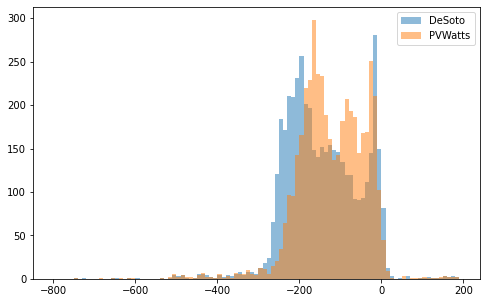

In [ ]:
# Develop your code here !

### Model improvement

Two ways to improve the initial estimation are shown in the following cells:

1. Add a term to the first estimation based on residual analysis
2. Perform regression on the DC PVWatts coefficients Pdc0 and the thermal coefficient gamma_pdc


#### Exercice: Improved Single Diode model

Adjust the initial estimation in a new pd.Series with the single diode model by adding it the mean residual error.

In [ ]:
# Develop your code here !

ME DeSoto: -0.0 W
ME DeSoto: -0.0 %
MAE DeSoto: 56.3 W


#### Exercice: Failure detection

- Define a threshold in W from the residual analysis to identify when the system underperforms compare to one of the estimate.
- Create a filter to detect failure/underperformances based on this threshold
- Create a new pd.Series with the same index as actual which includes the detected energy losses

In [ ]:
# Develop your code here !